In [1]:
import numpy as np  
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
% matplotlib inline

### Utility functions ###

Initialize graph with parameters for Q and S (D=Q+S)

In [2]:
def init_graph(L, N):
    mu_Q = (np.random.rand(N*L))*np.ones(L).repeat(N)
    mu_Q = mu_Q.reshape((L,N))
    mu_S = (np.random.rand(N*L))*np.ones(L).repeat(N)
    mu_S = mu_S.reshape((L,N))
    var_Q = (np.random.rand(N*L))*np.ones(L).repeat(N)
    var_Q = var_Q.reshape((L,N))
    var_S = (np.random.rand(N*L))*np.ones(L).repeat(N)
    var_S = var_S.reshape((L,N))
    
    return {"mu_Q":mu_Q, "mu_S":mu_S, "var_Q": var_Q, "var_S": var_S}

Given a LxN graph, pick a pair of paths that differ only by ith node fo layer *layer*

In [3]:
def path_pair(layer, i, j, L, N):
    path_i = np.random.choice(N, L)
    path_j = path_i.copy()
    path_i[layer] = i
    path_j[layer] = j
    
    return path_i, path_j

Draw P random delays for each node according to their distributions

In [4]:
def draw_delays(mu, var, P, distr):
    L = mu.shape[0]
    N = mu.shape[1]
    draw = []
    
    if distr == "exp":
        R = np.random.exponential(mu, size=(P,L,N))
    if distr == "gaussian":
        R = np.add(mu, np.multiply(np.power(var, 0.5), np.random.randn(P,L,N)))
    return np.abs(R)

Approximate the deviations for all the nodes of a layer

In [5]:
def approximate_diffs(layer, graph, distr, P):
    L = graph["mu_Q"].shape[0]
    N = graph["mu_Q"].shape[1]
    coefs = np.arange(1,N+1)[::-1]
            
    delays_Q = draw_delays(graph["mu_Q"], graph["var_Q"], P, distr["Q"])
    delays_S = draw_delays(graph["mu_S"], graph["var_S"], P, distr["S"])
    D = delays_Q + delays_S

    travel_times = []
    
    # we do not bother implement the log(N) comparison scheme, and compare everybody to everybody instead
    mu_diffs = np.zeros((N,N))
    var_diffs = np.zeros((N,N))
    for i in range(N-1):
        for j in range(i+1, N):
            path_i, path_j = path_pair(layer, i, j, L, N)
            travel_times_i = D[:, np.arange(L), path_i].sum(axis=1)
            travel_times_j = D[:, np.arange(L), path_j].sum(axis=1)
            
            mu_delay_i = travel_times_i.mean()
            mu_delay_j = travel_times_j.mean()
            
            mu_diffs[i,j] = mu_delay_i-mu_delay_j
            mu_diffs[j,i] = mu_delay_j-mu_delay_i
        
            var_delay_i = travel_times_i.var()
            var_delay_j = travel_times_j.var()
            
            var_diffs[i,j] = var_delay_i-var_delay_j
            var_diffs[j,i] = var_delay_j-var_delay_i

            travel_times += list(travel_times_i)
            travel_times += list(travel_times_j)

            
            
    return mu_diffs, var_diffs, travel_times

Returns the true and approximated differences of all the nodes within a given layer

In [11]:
def plot_graph(data, sla):
    L, N = data.shape[1], data.shape[2]
    plt.rcParams.update(plt.rcParamsDefault)    
    f, ax = plt.subplots(L, N, figsize=(20,12))
    
    max_X, max_Y = 0,0
    for l in range(L):
        for n in range(N):
            hist, bins = np.histogram(data[:,l,n], bins=100, density=0)
            center = (bins[:-1] + bins[1:]) / 2
            normalized = hist/np.sum(hist)
            ax[l][n].plot(center, normalized, label="(" + str(l)+","+str(n) + ")")
            max_X = max(max_X, center.max())
            max_Y = max(max_Y, normalized.max())
            t = np.mean(data[:,l,:]) + sla[l]
            max_X = max(max_X, t)


    for l in range(L):
        for n in range(N):
            mu = np.mean(data[:,l,n])
            ax[l][n].plot([mu, mu], [0, max_Y], "black", label="$\mu$")
            ax[l][n].set_xticks(np.around(np.arange(0, max_X, 0.25*max_X)))
            ax[l][n].set_yticks(np.arange(0, max_Y, np.around(0.25*max_Y, decimals=2)))
            ax[l][n].set_ylim((0, max_Y))
            ax[l][n].set_xlim((0, max_X))
            t = np.mean(data[:,l,:]) + sla[l] 
            ax[l][n].plot([t, t], [0, max_Y], "r--", label="sla")
            ax[l][n].legend()
    plt.show()


## Performance Monitoring: Random walk [mu_S] ###

Generate a graph with random distribution means

In [42]:
N = 4
L = 4
distr ={"Q":"exp", "S":"exp"}

graph = init_graph(L, N)
graph["mu_Q"][:] =0

for layer in range(L):
    graph["mu_S"][layer]+=(layer+1)*15
    
graph["var_Q"][:] =0
graph["var_S"][:] =1

sla = {"mu_Q"  : np.zeros(L),
       "var_Q" : np.zeros(L),
       "mu_S"  : np.zeros(L),
       "var_S" : np.zeros(L),
    }

sla_treshold = 0.5 # 50% of layer mean

for l in range(L):
    sla["mu_Q"][l] = np.mean(graph["mu_Q"][l])*sla_treshold
    sla["var_Q"][l] = np.mean(graph["var_Q"][l])*sla_treshold
    sla["mu_S"][l] = np.mean(graph["mu_S"][l])*sla_treshold
    sla["var_S"][l] = np.mean(graph["var_S"][l])*sla_treshold
    

    
graph["mu_S"], sla

(array([[ 15.92298773,  15.4311567 ,  15.7837185 ,  15.87247337],
        [ 30.59980528,  30.25734232,  30.66498733,  30.72278528],
        [ 45.06680166,  45.4589754 ,  45.20343618,  45.67951453],
        [ 60.16304403,  60.75837463,  60.94674637,  60.3046962 ]]),
 {'mu_Q': array([ 0.,  0.,  0.,  0.]),
  'mu_S': array([  7.87629204,  15.28061503,  22.67609097,  30.27160765]),
  'var_Q': array([ 0.,  0.,  0.,  0.]),
  'var_S': array([ 0.5,  0.5,  0.5,  0.5])})

## Queue time distribution

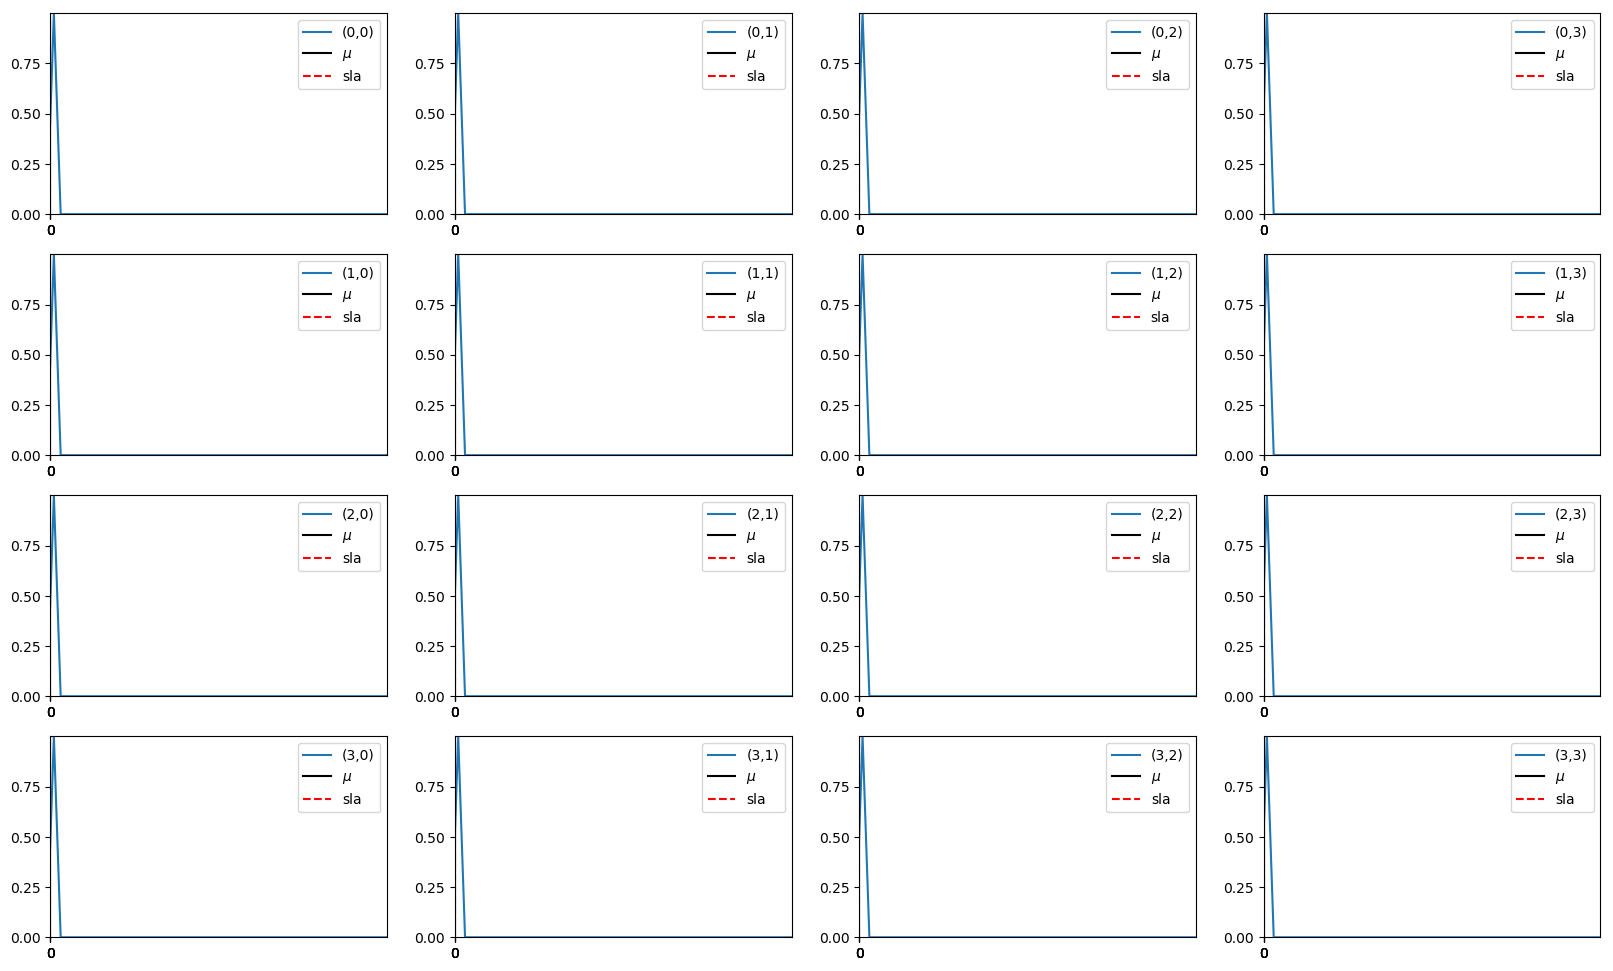

In [36]:
data_q = draw_delays(graph["mu_Q"], graph["var_Q"], P=10000, distr=distr["Q"])
plot_graph(data_q, sla=sla["mu_Q"])

## Service time distribution


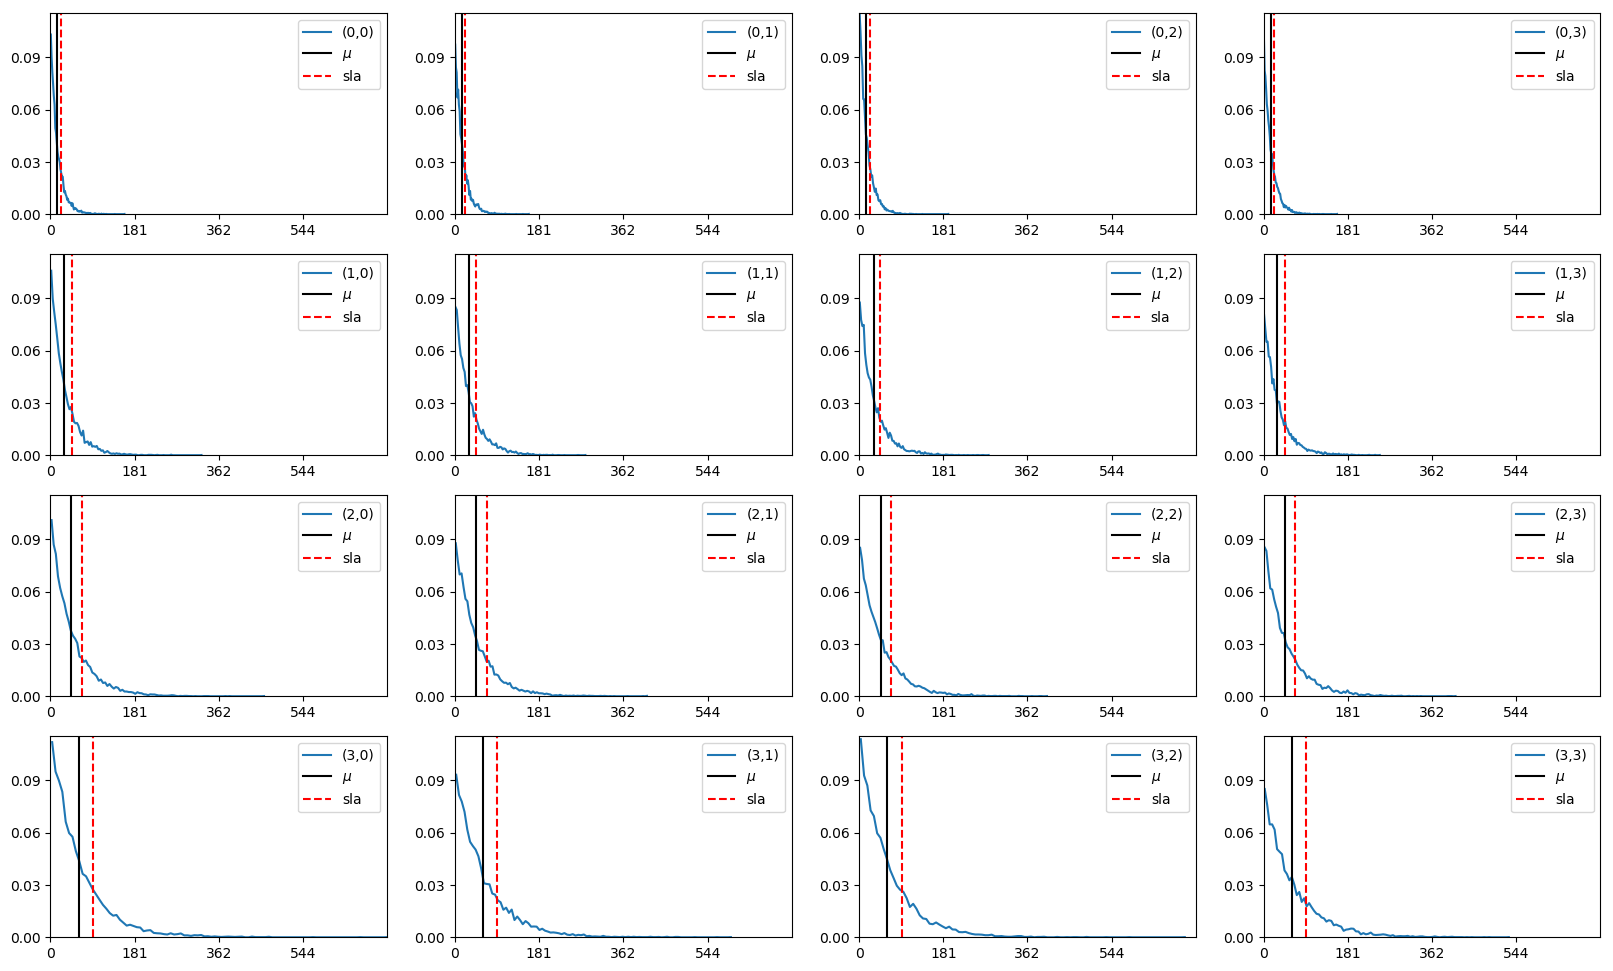

In [37]:
data_s = draw_delays(graph["mu_S"], graph["var_S"], P=10000, distr=distr["S"])
plot_graph(data_s, sla=sla["mu_S"])

## Delays distribution (Delay = Queue + Service)


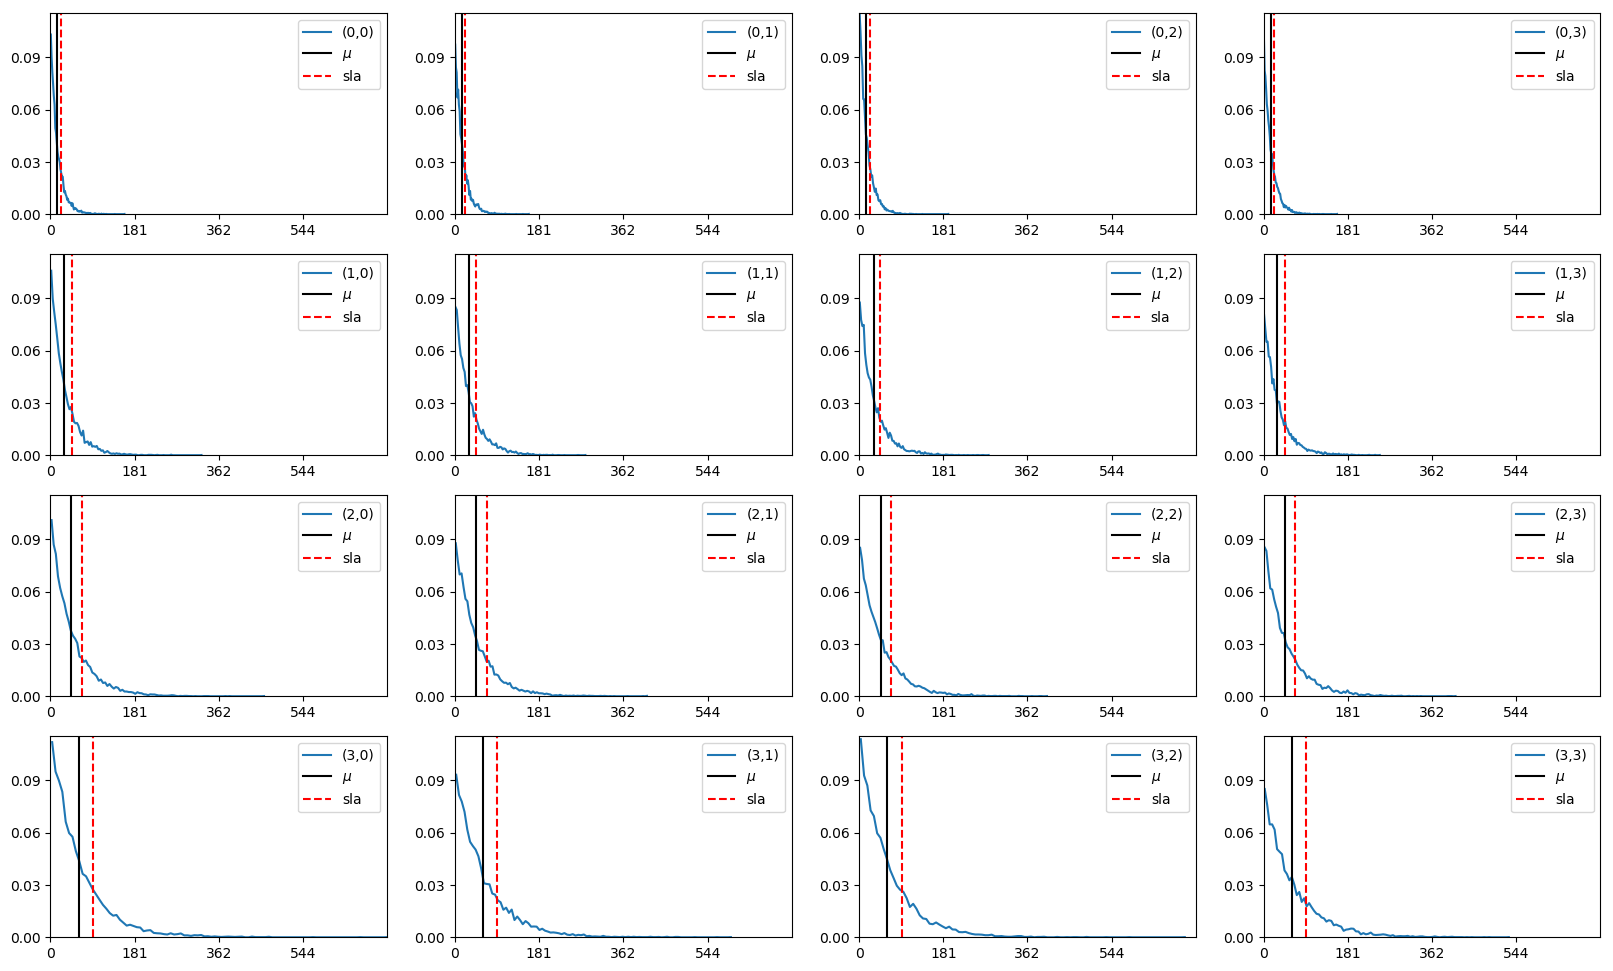

In [38]:
plot_graph(data_q+data_s, sla=sla["mu_S"])

Random walk during 700 timesteps, altering mu_S by a random number

In [43]:
steps = 701
win_size = 1
diff_mu_approx = np.zeros((steps, L, N)) 
mu = np.zeros((steps, L, N))

percentiles = np.zeros((steps, 5))

orig = graph["mu_S"].copy()
print(orig)
P=1500
migrate = defaultdict(list)

for s in range(steps):
    mu[s] = graph["mu_S"] + graph["mu_Q"] 
    travel_times = []
    for layer in range(L):
        diffs, diffs_var, trav_times = approximate_diffs(layer, graph, distr, P)
        travel_times += trav_times        
        
        #minimum = np.argsort(diffs.sum(axis=1))[0]
        #diff_mu_approx[s][layer] = -diffs[minimum]
        
        for node in range(N):
            while True:
                rand_node = np.random.choice(N)
                if rand_node != node:
                    diff_mu_approx[s][layer][node] = max(0,diffs[node][rand_node])
                    break
    
            roll = pd.Series(diff_mu_approx[:s+1,layer,node]).rolling(win_size, min_periods=1).mean()
            if roll.values[-1] > sla["mu_S"][layer]:
                migrate[layer].append((s, diff_mu_approx[s,layer,node]))
                print(s,"/", steps, "reset", layer, node, ":", graph["mu_S"][layer][node] , "to", orig[layer][node])
                graph["mu_S"][layer][node] = orig[layer][node]
    
            # random walk
            graph["mu_S"][layer][node] += 2*(layer+1)*(np.random.rand()-0.5)
            graph["mu_S"][layer][node] = max(graph["mu_S"][layer][node], orig[layer][node])
            
            if s > 600: # regime change --> traffic increases
                graph["mu_Q"][layer][node] += (layer+1)*(np.random.rand()-0.4)
                graph["mu_Q"][layer][node] = np.abs(graph["mu_Q"][layer][node])

                
            if s > 350 and s < 450: # one node gets more traffic than the rest
                if layer == 2 and node == 2:
                    graph["mu_Q"][layer][node] += (layer+1)*(np.random.rand()-0.2)
                    graph["mu_Q"][layer][node] = np.abs(graph["mu_Q"][layer][node])

            if s > 450 and s < 600: # node 2,2 gets back to normal
                if layer == 2 and node == 2:
                    graph["mu_Q"][layer][node] = 0
            

            len_tt = len(travel_times)
            
            
            
            #    graph["mu_Q"][layer][node] += (layer+1)*(np.random.rand()-0.3)
            #    graph["mu_Q"][layer][node] = max(graph["mu_Q"][layer][node], orig[layer][node])
                
            
    perc_idx = [x for x in range(int(len_tt/5), len_tt+1, int(len_tt/5))]
    perc_idx[-1] = perc_idx[-1]-1
    percentiles[s] = np.array(sorted(travel_times))[perc_idx]
    
graph["mu_S"]

[[ 15.92298773  15.4311567   15.7837185   15.87247337]
 [ 30.59980528  30.25734232  30.66498733  30.72278528]
 [ 45.06680166  45.4589754   45.20343618  45.67951453]
 [ 60.16304403  60.75837463  60.94674637  60.3046962 ]]
41 / 701 reset 0 3 : 24.9843925136 to 15.8724733704
93 / 701 reset 1 0 : 46.3606491117 to 30.599805284
128 / 701 reset 1 2 : 50.0089814801 to 30.6649873296
137 / 701 reset 3 2 : 91.8482578969 to 60.9467463677
155 / 701 reset 2 2 : 68.6240918189 to 45.2034361752
157 / 701 reset 2 1 : 65.1182876025 to 45.4589753986
177 / 701 reset 0 1 : 23.1957361042 to 15.4311567045
178 / 701 reset 3 0 : 94.9550467295 to 60.1630440298
214 / 701 reset 0 3 : 23.0310883834 to 15.8724733704
227 / 701 reset 1 0 : 47.4228764615 to 30.599805284
238 / 701 reset 1 2 : 47.2110249234 to 30.6649873296
284 / 701 reset 2 1 : 68.6454540766 to 45.4589753986
311 / 701 reset 2 2 : 75.2858595739 to 45.2034361752
331 / 701 reset 0 2 : 24.7823655327 to 15.783718504
345 / 701 reset 2 0 : 72.244055673 to 45.0

array([[ 15.92298773,  15.4311567 ,  18.09423527,  19.50607888],
       [ 39.21357473,  37.50038074,  38.48349245,  39.47280921],
       [ 55.73737307,  58.09720503,  63.47032949,  56.29082398],
       [ 70.64702893,  60.75837463,  65.13236361,  65.70612465]])

Plot the results

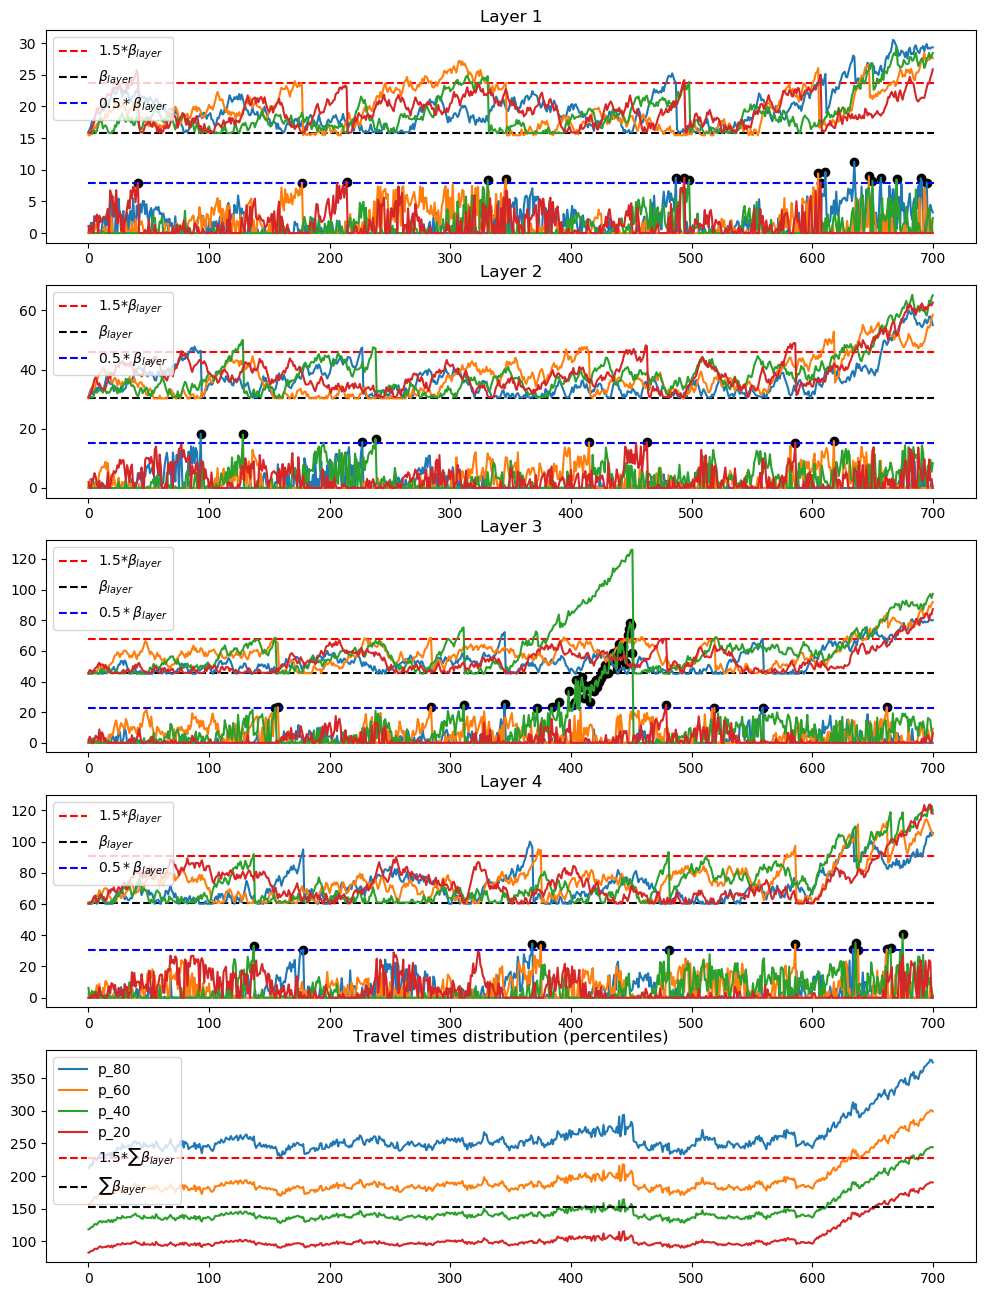

In [44]:
plt.rcParams.update(plt.rcParamsDefault)    
f, ax = plt.subplots(L+1, figsize=(12,16))

colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

for layer in range(L):

    
    
    t = np.mean(orig[layer]) + sla["mu_S"][layer] 
    ax[layer].plot([0, len(diff_mu_approx)], [t, t], "r--", label=r'1.5*$\beta_{layer}$')
    t = np.mean(orig[layer]) 
    ax[layer].plot([0, len(diff_mu_approx)], [t, t], "--", c="black", label=r"$\beta_{layer}$")

    ax[layer].plot([0, len(diff_mu_approx)], [sla["mu_S"][layer], sla["mu_S"][layer]], "b--", label=r"$0.5*\beta_{layer}$")

    ax[layer].scatter([x[0] for x in migrate[layer]], [x[1] for x in migrate[layer]], c="black", marker='o')
    
    for n in range(N):
        ax[layer].plot(diff_mu_approx[:,layer,n], color=colors[n])
        ax[layer].plot(mu[:,layer, n], color=colors[n])
    ax[layer].legend(loc="upper left")
    ax[layer].set_title("Layer " + str(layer+1))


for i in range(4,0,-1):
    label = "p_"+str((i)*20)
    ax[L].plot(percentiles[:,i-1], label=label)
    ax[L].set_title("Travel times distribution (percentiles)")

t = np.mean(orig, axis=1).sum() + np.sum(sla["mu_S"])
ax[L].plot([0, len(diff_mu_approx)], [t, t], "--", c="red", label=r"1.5*$\sum\beta_{layer}$")

t = np.mean(orig, axis=1).sum()
ax[L].plot([0, len(diff_mu_approx)], [t, t], "--", c="black", label=r"$\sum\beta_{layer}$")

ax[L].legend(loc="upper left")
plt.show()

# Min's simulations scenarios


# Experiment 1
- Node 0 in each layer starts to malfunction at timestep 150, with a max value of 2*$\beta^\mu_{layer}$. 
- Node 1 in each layer starts to get increased workload at timestep 350 , with a max value of 2*$\beta^q_{layer}$. 

In [128]:
N = 4
L = 4
distr ={"Q":"exp", "S":"exp"}

graph = init_graph(L, N)
graph["mu_Q"][:] =0

for layer in range(L):
    graph["mu_S"][layer]+=(layer+1)*15
    
graph["var_Q"][:] =0
graph["var_S"][:] =1

sla = {"mu_Q"  : np.zeros(L),
       "var_Q" : np.zeros(L),
       "mu_S"  : np.zeros(L),
       "var_S" : np.zeros(L),
    }

sla_treshold = 0.5 # 50% of layer mean

for l in range(L):
    sla["mu_Q"][l] = np.mean(graph["mu_Q"][l])*sla_treshold
    sla["var_Q"][l] = np.mean(graph["var_Q"][l])*sla_treshold
    sla["mu_S"][l] = np.mean(graph["mu_S"][l])*sla_treshold
    sla["var_S"][l] = np.mean(graph["var_S"][l])*sla_treshold
    
graph["mu_S"], sla

(array([[ 15.02586722,  15.40107639,  15.04311251,  15.68557392],
        [ 30.76587305,  30.00038069,  30.67200451,  30.35595037],
        [ 45.32439083,  45.6161716 ,  45.02232081,  45.19059704],
        [ 60.85954013,  60.43291498,  60.51346161,  60.67294146]]),
 {'mu_Q': array([ 0.,  0.,  0.,  0.]),
  'mu_S': array([  7.64445375,  15.22427608,  22.64418503,  30.30985727]),
  'var_Q': array([ 0.,  0.,  0.,  0.]),
  'var_S': array([ 0.5,  0.5,  0.5,  0.5])})

In [129]:
steps = 501
win_size = 1
diff_mu_approx = np.zeros((steps, L, N)) 
mu = np.zeros((steps, L, N))

percentiles = np.zeros((steps, 5))

orig = graph["mu_S"].copy()
orig_q = graph["mu_Q"].copy()

print()

print(orig)
P=500
migrate = defaultdict(list)

for s in range(steps):
    mu[s] = graph["mu_S"] + graph["mu_Q"] 
    travel_times = []
    for layer in range(L):
        diffs, diffs_var, trav_times = approximate_diffs(layer, graph, distr, P)
        travel_times += trav_times        
        
        #minimum = np.argsort(diffs.sum(axis=1))[0]
        #diff_mu_approx[s][layer] = -diffs[minimum]
        
        for node in range(N):
            #compare each node to a random node
            while True:
                rand_node = np.random.choice(N)
                if rand_node != node:
                    diff_mu_approx[s][layer][node] = max(0,diffs[node][rand_node])
                    break
       
            if s > 100 and s < 200: # regime change --> traffic increases
                graph["mu_S"][layer][0] += (layer+1)*(np.random.rand()-0.4)
                graph["mu_S"][layer][0] = min(graph["mu_S"][layer][0], 1.75*orig[layer][0])
            
            if s == 200: # regime change --> traffic increases
                graph["mu_S"][layer][0] = orig[layer][0]
            

            if s > 300 and s < 400: # regime change --> traffic increases
                graph["mu_Q"][layer][1] += (layer+1)*(np.random.rand()-0.4)
                graph["mu_Q"][layer][1] = np.abs(graph["mu_Q"][layer][1])
                graph["mu_Q"][layer][1] = min(graph["mu_Q"][layer][1], 0.75*orig[layer][0])
                
            if s == 400: # regime change --> traffic increases
                graph["mu_Q"][layer][1] = orig_q[layer][1]
            

            len_tt = len(travel_times)          
            
            #    graph["mu_Q"][layer][node] += (layer+1)*(np.random.rand()-0.3)
            #    graph["mu_Q"][layer][node] = max(graph["mu_Q"][layer][node], orig[layer][node])
                
            
    perc_idx = [x for x in range(int(len_tt/5), len_tt+1, int(len_tt/5))]
    perc_idx[-1] = perc_idx[-1]-1
    percentiles[s] = np.array(sorted(travel_times))[perc_idx]
    
graph["mu_S"], graph["mu_Q"]


[[ 15.02586722  15.40107639  15.04311251  15.68557392]
 [ 30.76587305  30.00038069  30.67200451  30.35595037]
 [ 45.32439083  45.6161716   45.02232081  45.19059704]
 [ 60.85954013  60.43291498  60.51346161  60.67294146]]


(array([[ 15.02586722,  15.40107639,  15.04311251,  15.68557392],
        [ 30.76587305,  30.00038069,  30.67200451,  30.35595037],
        [ 45.32439083,  45.6161716 ,  45.02232081,  45.19059704],
        [ 60.85954013,  60.43291498,  60.51346161,  60.67294146]]),
 array([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.]]))

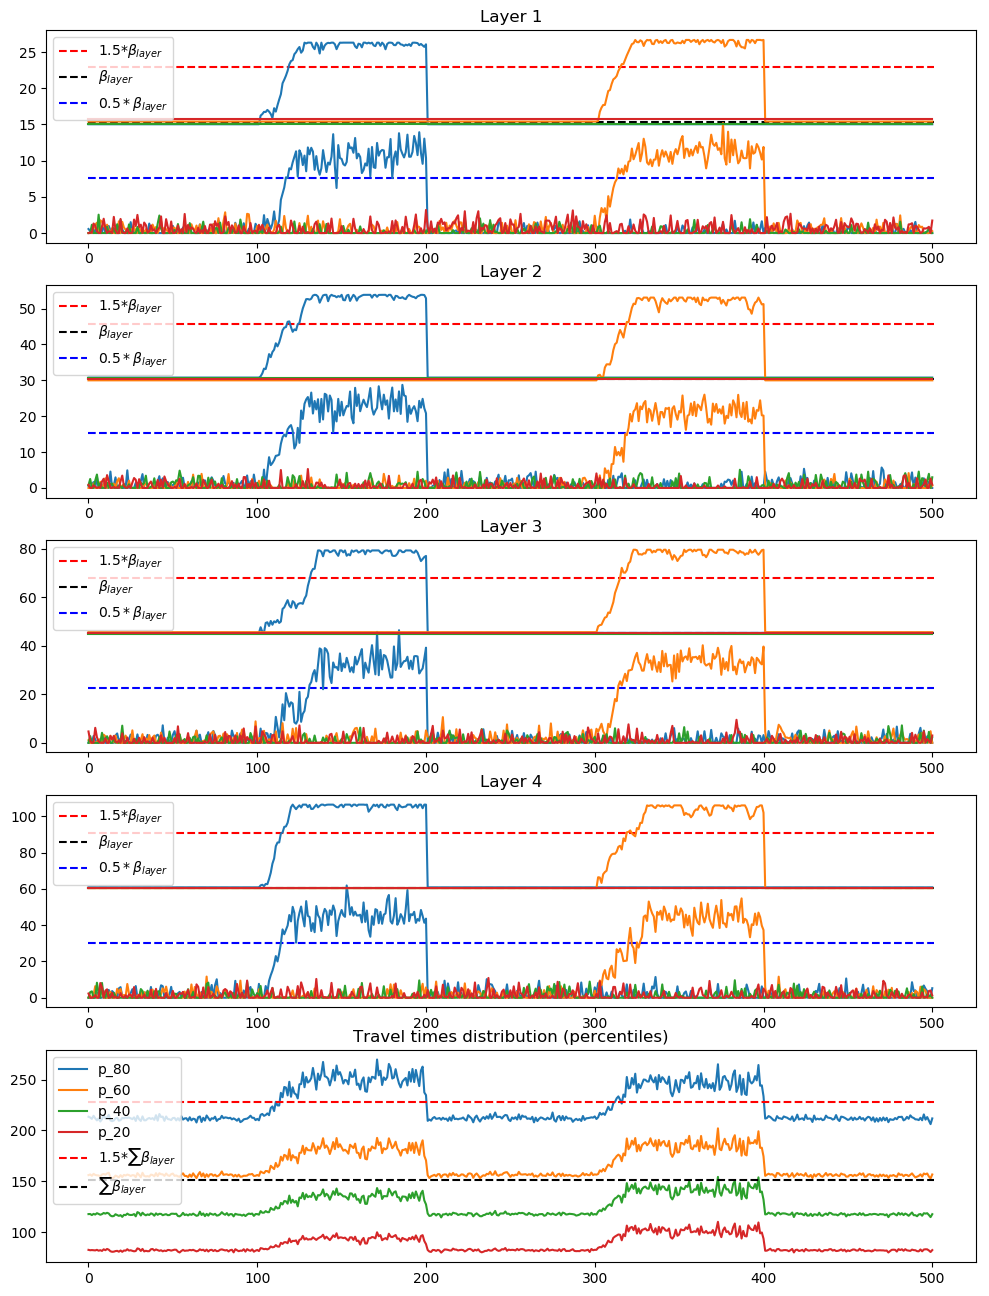

In [130]:
plt.rcParams.update(plt.rcParamsDefault)    
f, ax = plt.subplots(L+1, figsize=(12,16))

colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

for layer in range(L):   
    t = np.mean(orig[layer]) + sla["mu_S"][layer] 
    ax[layer].plot([0, len(diff_mu_approx)], [t, t], "r--", label=r'1.5*$\beta_{layer}$')
    t = np.mean(orig[layer]) 
    ax[layer].plot([0, len(diff_mu_approx)], [t, t], "--", c="black", label=r"$\beta_{layer}$")

    ax[layer].plot([0, len(diff_mu_approx)], [sla["mu_S"][layer], sla["mu_S"][layer]], "b--", label=r"$0.5*\beta_{layer}$")

    ax[layer].scatter([x[0] for x in migrate[layer]], [x[1] for x in migrate[layer]], c="black", marker='o')
    
    for n in range(N):
        ax[layer].plot(diff_mu_approx[:,layer,n], color=colors[n])
        ax[layer].plot(mu[:,layer, n], color=colors[n])
    ax[layer].legend(loc="upper left")
    ax[layer].set_title("Layer " + str(layer+1))


for i in range(4,0,-1):
    label = "p_"+str((i)*20)
    ax[L].plot(percentiles[:,i-1], label=label)
    ax[L].set_title("Travel times distribution (percentiles)")

t = np.mean(orig, axis=1).sum() + np.sum(sla["mu_S"])
ax[L].plot([0, len(diff_mu_approx)], [t, t], "--", c="red", label=r"1.5*$\sum\beta_{layer}$")

t = np.mean(orig, axis=1).sum()
ax[L].plot([0, len(diff_mu_approx)], [t, t], "--", c="black", label=r"$\sum\beta_{layer}$")

ax[L].legend(loc="upper left")
plt.show()

# Experiment 2
- Node 0 in each layer starts to malfunction at timestep 150. We perform migrations. 

In [131]:
N = 4
L = 4
distr ={"Q":"exp", "S":"exp"}

graph = init_graph(L, N)
graph["mu_Q"][:] =0

for layer in range(L):
    graph["mu_S"][layer]+=(layer+1)*15
    
graph["var_Q"][:] =0
graph["var_S"][:] =1

sla = {"mu_Q"  : np.zeros(L),
       "var_Q" : np.zeros(L),
       "mu_S"  : np.zeros(L),
       "var_S" : np.zeros(L),
    }

sla_treshold = 0.5 # 50% of layer mean

for l in range(L):
    sla["mu_Q"][l] = np.mean(graph["mu_Q"][l])*sla_treshold
    sla["var_Q"][l] = np.mean(graph["var_Q"][l])*sla_treshold
    sla["mu_S"][l] = np.mean(graph["mu_S"][l])*sla_treshold
    sla["var_S"][l] = np.mean(graph["var_S"][l])*sla_treshold
    
graph["mu_S"], sla

(array([[ 15.90484158,  15.54149213,  15.5417191 ,  15.38951161],
        [ 30.49104685,  30.99186881,  30.70624181,  30.45193131],
        [ 45.40557886,  45.19293362,  45.955794  ,  45.15700754],
        [ 60.01114084,  60.75199243,  60.94875772,  60.53951621]]),
 {'mu_Q': array([ 0.,  0.,  0.,  0.]),
  'mu_S': array([  7.79719555,  15.3301361 ,  22.71391425,  30.2814259 ]),
  'var_Q': array([ 0.,  0.,  0.,  0.]),
  'var_S': array([ 0.5,  0.5,  0.5,  0.5])})

In [132]:
steps = 501
win_size = 1
diff_mu_approx = np.zeros((steps, L, N)) 
mu = np.zeros((steps, L, N))

percentiles = np.zeros((steps, 5))

orig = graph["mu_S"].copy()
orig_q = graph["mu_Q"].copy()

print()

print(orig)
P=500
migrate = defaultdict(list)

for s in range(steps):
    mu[s] = graph["mu_S"] + graph["mu_Q"] 
    travel_times = []
    for layer in range(L):
        diffs, diffs_var, trav_times = approximate_diffs(layer, graph, distr, P)
        travel_times += trav_times        
        
        #minimum = np.argsort(diffs.sum(axis=1))[0]
        #diff_mu_approx[s][layer] = -diffs[minimum]
        
        for node in range(N):
            #compare each node to a random node
            while True:
                rand_node = np.random.choice(N)
                if rand_node != node:
                    diff_mu_approx[s][layer][node] = max(0,diffs[node][rand_node])
                    break
    
            if s > 100 : # regime change --> traffic increases
                graph["mu_S"][layer][0] += (layer+1)*(np.random.rand()-0.4)
                
            roll = pd.Series(diff_mu_approx[:s+1,layer,node]).rolling(win_size, min_periods=1).mean()
            if roll.values[-1] > sla["mu_S"][layer]:
                migrate[layer].append((s, diff_mu_approx[s,layer,node]))
                print(s,"/", steps, "reset", layer, node, ":", graph["mu_S"][layer][node] , "to", orig[layer][node])
                graph["mu_S"][layer][node] = orig[layer][node]

            len_tt = len(travel_times)          
            
            #    graph["mu_Q"][layer][node] += (layer+1)*(np.random.rand()-0.3)
            #    graph["mu_Q"][layer][node] = max(graph["mu_Q"][layer][node], orig[layer][node])
                
            
    perc_idx = [x for x in range(int(len_tt/5), len_tt+1, int(len_tt/5))]
    perc_idx[-1] = perc_idx[-1]-1
    percentiles[s] = np.array(sorted(travel_times))[perc_idx]
    
graph["mu_S"], graph["mu_Q"]


[[ 15.90484158  15.54149213  15.5417191   15.38951161]
 [ 30.49104685  30.99186881  30.70624181  30.45193131]
 [ 45.40557886  45.19293362  45.955794    45.15700754]
 [ 60.01114084  60.75199243  60.94875772  60.53951621]]
117 / 501 reset 0 0 : 24.9838799088 to 15.9048415835
120 / 501 reset 1 0 : 48.4805694923 to 30.4910468486
121 / 501 reset 2 0 : 71.4904213202 to 45.4055788561
123 / 501 reset 3 0 : 89.9530754643 to 60.0111408434
135 / 501 reset 1 0 : 42.7301900657 to 30.4910468486
135 / 501 reset 2 0 : 66.5187280909 to 45.4055788561
139 / 501 reset 3 0 : 86.6925691238 to 60.0111408434
146 / 501 reset 0 0 : 22.4037414854 to 15.9048415835
151 / 501 reset 1 0 : 47.0637943235 to 30.4910468486
151 / 501 reset 3 0 : 93.7235156545 to 60.0111408434
152 / 501 reset 2 0 : 67.6658610188 to 45.4055788561
161 / 501 reset 0 0 : 24.3556569862 to 15.9048415835
167 / 501 reset 2 0 : 69.0538722212 to 45.4055788561
171 / 501 reset 3 0 : 87.7855747238 to 60.0111408434
179 / 501 reset 0 0 : 23.8785200102 

(array([[ 16.63749808,  15.54149213,  15.5417191 ,  15.38951161],
        [ 31.03650579,  30.99186881,  30.70624181,  30.45193131],
        [ 50.54154346,  45.19293362,  45.955794  ,  45.15700754],
        [ 71.49805213,  60.75199243,  60.94875772,  60.53951621]]),
 array([[ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.]]))

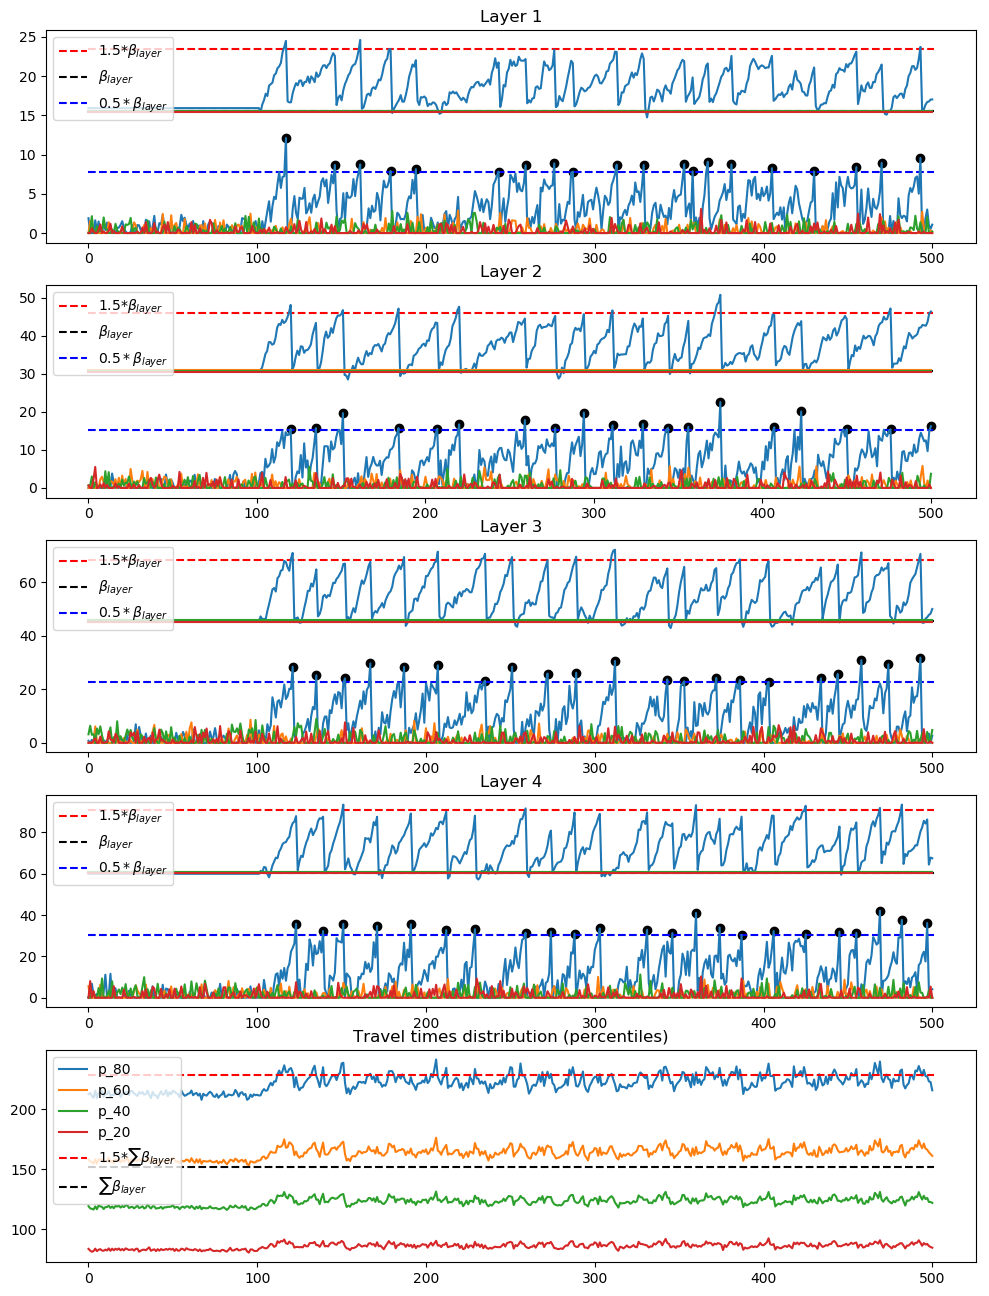

In [133]:
plt.rcParams.update(plt.rcParamsDefault)    
f, ax = plt.subplots(L+1, figsize=(12,16))

colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

for layer in range(L):   
    t = np.mean(orig[layer]) + sla["mu_S"][layer] 
    ax[layer].plot([0, len(diff_mu_approx)], [t, t], "r--", label=r'1.5*$\beta_{layer}$')
    t = np.mean(orig[layer]) 
    ax[layer].plot([0, len(diff_mu_approx)], [t, t], "--", c="black", label=r"$\beta_{layer}$")

    ax[layer].plot([0, len(diff_mu_approx)], [sla["mu_S"][layer], sla["mu_S"][layer]], "b--", label=r"$0.5*\beta_{layer}$")

    ax[layer].scatter([x[0] for x in migrate[layer]], [x[1] for x in migrate[layer]], c="black", marker='o')
    
    for n in range(N):
        ax[layer].plot(diff_mu_approx[:,layer,n], color=colors[n])
        ax[layer].plot(mu[:,layer, n], color=colors[n])
    ax[layer].legend(loc="upper left")
    ax[layer].set_title("Layer " + str(layer+1))


for i in range(4,0,-1):
    label = "p_"+str((i)*20)
    ax[L].plot(percentiles[:,i-1], label=label)
    ax[L].set_title("Travel times distribution (percentiles)")

t = np.mean(orig, axis=1).sum() + np.sum(sla["mu_S"])
ax[L].plot([0, len(diff_mu_approx)], [t, t], "--", c="red", label=r"1.5*$\sum\beta_{layer}$")

t = np.mean(orig, axis=1).sum()
ax[L].plot([0, len(diff_mu_approx)], [t, t], "--", c="black", label=r"$\sum\beta_{layer}$")

ax[L].legend(loc="upper left")
plt.show()

# Experiment 3
- Node 0 in each layer gets more traffic than the rest (amounts to 0.75*$\beta_{layer}$). We keep performing migrations. But it is not the appropriated solution.

In [151]:
N = 4
L = 4
distr ={"Q":"exp", "S":"exp"}

graph = init_graph(L, N)
graph["mu_Q"][:] =0

for layer in range(L):
    graph["mu_S"][layer]+=(layer+1)*15
    
graph["var_Q"][:] =0
graph["var_S"][:] =1

sla = {"mu_Q"  : np.zeros(L),
       "var_Q" : np.zeros(L),
       "mu_S"  : np.zeros(L),
       "var_S" : np.zeros(L),
    }

sla_treshold = 0.5 # 50% of layer mean

for l in range(L):
    sla["mu_Q"][l] = np.mean(graph["mu_Q"][l])*sla_treshold
    sla["var_Q"][l] = np.mean(graph["var_Q"][l])*sla_treshold
    sla["mu_S"][l] = np.mean(graph["mu_S"][l])*sla_treshold
    sla["var_S"][l] = np.mean(graph["var_S"][l])*sla_treshold
    
graph["mu_S"], sla

(array([[ 15.88434609,  15.39690259,  15.3149046 ,  15.88787937],
        [ 30.26900867,  30.36667257,  30.07884397,  30.20675933],
        [ 45.36539394,  45.88824556,  45.25442159,  45.30787526],
        [ 60.35737711,  60.15038116,  60.60374131,  60.16576653]]),
 {'mu_Q': array([ 0.,  0.,  0.,  0.]),
  'mu_S': array([  7.81050408,  15.11516057,  22.72699204,  30.15965826]),
  'var_Q': array([ 0.,  0.,  0.,  0.]),
  'var_S': array([ 0.5,  0.5,  0.5,  0.5])})

In [152]:
steps = 501
win_size = 1
diff_mu_approx = np.zeros((steps, L, N)) 
mu = np.zeros((steps, L, N))

percentiles = np.zeros((steps, 5))

orig = graph["mu_S"].copy()
orig_q = graph["mu_Q"].copy()

print()

print(orig)
P=500
migrate = defaultdict(list)

for s in range(steps):
    mu[s] = graph["mu_S"] + graph["mu_Q"] 
    travel_times = []
    for layer in range(L):
        diffs, diffs_var, trav_times = approximate_diffs(layer, graph, distr, P)
        travel_times += trav_times        
        
        #minimum = np.argsort(diffs.sum(axis=1))[0]
        #diff_mu_approx[s][layer] = -diffs[minimum]
        
        for node in range(N):
            #compare each node to a random node
            while True:
                rand_node = np.random.choice(N)
                if rand_node != node:
                    diff_mu_approx[s][layer][node] = max(0,diffs[node][rand_node])
                    break
 
            if s > 100 : # regime change --> traffic increases
                graph["mu_Q"][layer][0] += (layer+1)*(np.random.rand()-0.4)
                graph["mu_Q"][layer][0] = np.abs(graph["mu_Q"][layer][0])
                graph["mu_Q"][layer][0] = min(graph["mu_Q"][layer][0], 0.75*orig[layer][0])

                
            roll = pd.Series(diff_mu_approx[:s+1,layer,node]).rolling(win_size, min_periods=1).mean()
            if roll.values[-1] > sla["mu_S"][layer]:
                migrate[layer].append((s, diff_mu_approx[s,layer,node]))
                print(s,"/", steps, "reset", layer, node, ":", graph["mu_S"][layer][node] , "to", orig[layer][node])
                graph["mu_S"][layer][node] = orig[layer][node]

            len_tt = len(travel_times)          
            
            #    graph["mu_Q"][layer][node] += (layer+1)*(np.random.rand()-0.3)
            #    graph["mu_Q"][layer][node] = max(graph["mu_Q"][layer][node], orig[layer][node])
                
            
    perc_idx = [x for x in range(int(len_tt/5), len_tt+1, int(len_tt/5))]
    perc_idx[-1] = perc_idx[-1]-1
    percentiles[s] = np.array(sorted(travel_times))[perc_idx]
    
graph["mu_S"], graph["mu_Q"]


[[ 15.88434609  15.39690259  15.3149046   15.88787937]
 [ 30.26900867  30.36667257  30.07884397  30.20675933]
 [ 45.36539394  45.88824556  45.25442159  45.30787526]
 [ 60.35737711  60.15038116  60.60374131  60.16576653]]
119 / 501 reset 3 0 : 60.357377113 to 60.357377113
120 / 501 reset 0 0 : 15.8843460906 to 15.8843460906
120 / 501 reset 3 0 : 60.357377113 to 60.357377113
121 / 501 reset 0 0 : 15.8843460906 to 15.8843460906
121 / 501 reset 2 0 : 45.3653939399 to 45.3653939399
121 / 501 reset 3 0 : 60.357377113 to 60.357377113
122 / 501 reset 0 0 : 15.8843460906 to 15.8843460906
122 / 501 reset 3 0 : 60.357377113 to 60.357377113
123 / 501 reset 0 0 : 15.8843460906 to 15.8843460906
123 / 501 reset 3 0 : 60.357377113 to 60.357377113
124 / 501 reset 0 0 : 15.8843460906 to 15.8843460906
124 / 501 reset 2 0 : 45.3653939399 to 45.3653939399
124 / 501 reset 3 0 : 60.357377113 to 60.357377113
125 / 501 reset 0 0 : 15.8843460906 to 15.8843460906
125 / 501 reset 2 0 : 45.3653939399 to 45.365393

175 / 501 reset 1 0 : 30.2690086687 to 30.2690086687
175 / 501 reset 2 0 : 45.3653939399 to 45.3653939399
175 / 501 reset 3 0 : 60.357377113 to 60.357377113
176 / 501 reset 0 0 : 15.8843460906 to 15.8843460906
176 / 501 reset 1 0 : 30.2690086687 to 30.2690086687
176 / 501 reset 2 0 : 45.3653939399 to 45.3653939399
176 / 501 reset 3 0 : 60.357377113 to 60.357377113
177 / 501 reset 0 0 : 15.8843460906 to 15.8843460906
177 / 501 reset 1 0 : 30.2690086687 to 30.2690086687
177 / 501 reset 2 0 : 45.3653939399 to 45.3653939399
177 / 501 reset 3 0 : 60.357377113 to 60.357377113
178 / 501 reset 0 0 : 15.8843460906 to 15.8843460906
178 / 501 reset 1 0 : 30.2690086687 to 30.2690086687
178 / 501 reset 2 0 : 45.3653939399 to 45.3653939399
178 / 501 reset 3 0 : 60.357377113 to 60.357377113
179 / 501 reset 0 0 : 15.8843460906 to 15.8843460906
179 / 501 reset 1 0 : 30.2690086687 to 30.2690086687
179 / 501 reset 2 0 : 45.3653939399 to 45.3653939399
179 / 501 reset 3 0 : 60.357377113 to 60.357377113
180

224 / 501 reset 3 0 : 60.357377113 to 60.357377113
225 / 501 reset 0 0 : 15.8843460906 to 15.8843460906
225 / 501 reset 1 0 : 30.2690086687 to 30.2690086687
225 / 501 reset 2 0 : 45.3653939399 to 45.3653939399
225 / 501 reset 3 0 : 60.357377113 to 60.357377113
226 / 501 reset 0 0 : 15.8843460906 to 15.8843460906
226 / 501 reset 1 0 : 30.2690086687 to 30.2690086687
226 / 501 reset 2 0 : 45.3653939399 to 45.3653939399
226 / 501 reset 3 0 : 60.357377113 to 60.357377113
227 / 501 reset 0 0 : 15.8843460906 to 15.8843460906
227 / 501 reset 1 0 : 30.2690086687 to 30.2690086687
227 / 501 reset 2 0 : 45.3653939399 to 45.3653939399
227 / 501 reset 3 0 : 60.357377113 to 60.357377113
228 / 501 reset 0 0 : 15.8843460906 to 15.8843460906
228 / 501 reset 1 0 : 30.2690086687 to 30.2690086687
228 / 501 reset 2 0 : 45.3653939399 to 45.3653939399
228 / 501 reset 3 0 : 60.357377113 to 60.357377113
229 / 501 reset 0 0 : 15.8843460906 to 15.8843460906
229 / 501 reset 1 0 : 30.2690086687 to 30.2690086687
229

273 / 501 reset 0 0 : 15.8843460906 to 15.8843460906
273 / 501 reset 1 0 : 30.2690086687 to 30.2690086687
273 / 501 reset 2 0 : 45.3653939399 to 45.3653939399
273 / 501 reset 3 0 : 60.357377113 to 60.357377113
274 / 501 reset 0 0 : 15.8843460906 to 15.8843460906
274 / 501 reset 1 0 : 30.2690086687 to 30.2690086687
274 / 501 reset 2 0 : 45.3653939399 to 45.3653939399
274 / 501 reset 3 0 : 60.357377113 to 60.357377113
275 / 501 reset 0 0 : 15.8843460906 to 15.8843460906
275 / 501 reset 1 0 : 30.2690086687 to 30.2690086687
275 / 501 reset 2 0 : 45.3653939399 to 45.3653939399
275 / 501 reset 3 0 : 60.357377113 to 60.357377113
276 / 501 reset 0 0 : 15.8843460906 to 15.8843460906
276 / 501 reset 1 0 : 30.2690086687 to 30.2690086687
276 / 501 reset 2 0 : 45.3653939399 to 45.3653939399
276 / 501 reset 3 0 : 60.357377113 to 60.357377113
277 / 501 reset 0 0 : 15.8843460906 to 15.8843460906
277 / 501 reset 1 0 : 30.2690086687 to 30.2690086687
277 / 501 reset 2 0 : 45.3653939399 to 45.3653939399
2

312 / 501 reset 3 0 : 60.357377113 to 60.357377113
313 / 501 reset 0 0 : 15.8843460906 to 15.8843460906
313 / 501 reset 1 0 : 30.2690086687 to 30.2690086687
313 / 501 reset 2 0 : 45.3653939399 to 45.3653939399
313 / 501 reset 3 0 : 60.357377113 to 60.357377113
314 / 501 reset 0 0 : 15.8843460906 to 15.8843460906
314 / 501 reset 1 0 : 30.2690086687 to 30.2690086687
314 / 501 reset 2 0 : 45.3653939399 to 45.3653939399
314 / 501 reset 3 0 : 60.357377113 to 60.357377113
315 / 501 reset 0 0 : 15.8843460906 to 15.8843460906
315 / 501 reset 1 0 : 30.2690086687 to 30.2690086687
315 / 501 reset 2 0 : 45.3653939399 to 45.3653939399
315 / 501 reset 3 0 : 60.357377113 to 60.357377113
316 / 501 reset 0 0 : 15.8843460906 to 15.8843460906
316 / 501 reset 1 0 : 30.2690086687 to 30.2690086687
316 / 501 reset 2 0 : 45.3653939399 to 45.3653939399
316 / 501 reset 3 0 : 60.357377113 to 60.357377113
317 / 501 reset 0 0 : 15.8843460906 to 15.8843460906
317 / 501 reset 1 0 : 30.2690086687 to 30.2690086687
317

361 / 501 reset 1 0 : 30.2690086687 to 30.2690086687
361 / 501 reset 2 0 : 45.3653939399 to 45.3653939399
361 / 501 reset 3 0 : 60.357377113 to 60.357377113
362 / 501 reset 0 0 : 15.8843460906 to 15.8843460906
362 / 501 reset 1 0 : 30.2690086687 to 30.2690086687
362 / 501 reset 2 0 : 45.3653939399 to 45.3653939399
362 / 501 reset 3 0 : 60.357377113 to 60.357377113
363 / 501 reset 0 0 : 15.8843460906 to 15.8843460906
363 / 501 reset 1 0 : 30.2690086687 to 30.2690086687
363 / 501 reset 2 0 : 45.3653939399 to 45.3653939399
363 / 501 reset 3 0 : 60.357377113 to 60.357377113
364 / 501 reset 0 0 : 15.8843460906 to 15.8843460906
364 / 501 reset 1 0 : 30.2690086687 to 30.2690086687
364 / 501 reset 2 0 : 45.3653939399 to 45.3653939399
364 / 501 reset 3 0 : 60.357377113 to 60.357377113
365 / 501 reset 0 0 : 15.8843460906 to 15.8843460906
365 / 501 reset 1 0 : 30.2690086687 to 30.2690086687
365 / 501 reset 2 0 : 45.3653939399 to 45.3653939399
365 / 501 reset 3 0 : 60.357377113 to 60.357377113
366

401 / 501 reset 3 0 : 60.357377113 to 60.357377113
402 / 501 reset 0 0 : 15.8843460906 to 15.8843460906
402 / 501 reset 1 0 : 30.2690086687 to 30.2690086687
402 / 501 reset 2 0 : 45.3653939399 to 45.3653939399
402 / 501 reset 3 0 : 60.357377113 to 60.357377113
403 / 501 reset 0 0 : 15.8843460906 to 15.8843460906
403 / 501 reset 1 0 : 30.2690086687 to 30.2690086687
403 / 501 reset 2 0 : 45.3653939399 to 45.3653939399
403 / 501 reset 3 0 : 60.357377113 to 60.357377113
404 / 501 reset 0 0 : 15.8843460906 to 15.8843460906
404 / 501 reset 1 0 : 30.2690086687 to 30.2690086687
404 / 501 reset 2 0 : 45.3653939399 to 45.3653939399
404 / 501 reset 3 0 : 60.357377113 to 60.357377113
405 / 501 reset 0 0 : 15.8843460906 to 15.8843460906
405 / 501 reset 1 0 : 30.2690086687 to 30.2690086687
405 / 501 reset 2 0 : 45.3653939399 to 45.3653939399
405 / 501 reset 3 0 : 60.357377113 to 60.357377113
406 / 501 reset 0 0 : 15.8843460906 to 15.8843460906
406 / 501 reset 1 0 : 30.2690086687 to 30.2690086687
406

447 / 501 reset 2 0 : 45.3653939399 to 45.3653939399
447 / 501 reset 3 0 : 60.357377113 to 60.357377113
448 / 501 reset 0 0 : 15.8843460906 to 15.8843460906
448 / 501 reset 1 0 : 30.2690086687 to 30.2690086687
448 / 501 reset 2 0 : 45.3653939399 to 45.3653939399
448 / 501 reset 3 0 : 60.357377113 to 60.357377113
449 / 501 reset 0 0 : 15.8843460906 to 15.8843460906
449 / 501 reset 1 0 : 30.2690086687 to 30.2690086687
449 / 501 reset 2 0 : 45.3653939399 to 45.3653939399
449 / 501 reset 3 0 : 60.357377113 to 60.357377113
450 / 501 reset 0 0 : 15.8843460906 to 15.8843460906
450 / 501 reset 1 0 : 30.2690086687 to 30.2690086687
450 / 501 reset 2 0 : 45.3653939399 to 45.3653939399
450 / 501 reset 3 0 : 60.357377113 to 60.357377113
451 / 501 reset 0 0 : 15.8843460906 to 15.8843460906
451 / 501 reset 1 0 : 30.2690086687 to 30.2690086687
451 / 501 reset 2 0 : 45.3653939399 to 45.3653939399
452 / 501 reset 0 0 : 15.8843460906 to 15.8843460906
452 / 501 reset 1 0 : 30.2690086687 to 30.2690086687
4

491 / 501 reset 1 0 : 30.2690086687 to 30.2690086687
491 / 501 reset 2 0 : 45.3653939399 to 45.3653939399
491 / 501 reset 3 0 : 60.357377113 to 60.357377113
492 / 501 reset 0 0 : 15.8843460906 to 15.8843460906
492 / 501 reset 1 0 : 30.2690086687 to 30.2690086687
492 / 501 reset 2 0 : 45.3653939399 to 45.3653939399
492 / 501 reset 3 0 : 60.357377113 to 60.357377113
493 / 501 reset 0 0 : 15.8843460906 to 15.8843460906
493 / 501 reset 1 0 : 30.2690086687 to 30.2690086687
493 / 501 reset 2 0 : 45.3653939399 to 45.3653939399
493 / 501 reset 3 0 : 60.357377113 to 60.357377113
494 / 501 reset 0 0 : 15.8843460906 to 15.8843460906
494 / 501 reset 1 0 : 30.2690086687 to 30.2690086687
494 / 501 reset 2 0 : 45.3653939399 to 45.3653939399
494 / 501 reset 3 0 : 60.357377113 to 60.357377113
495 / 501 reset 0 0 : 15.8843460906 to 15.8843460906
495 / 501 reset 1 0 : 30.2690086687 to 30.2690086687
495 / 501 reset 3 0 : 60.357377113 to 60.357377113
496 / 501 reset 0 0 : 15.8843460906 to 15.8843460906
496

(array([[ 15.88434609,  15.39690259,  15.3149046 ,  15.88787937],
        [ 30.26900867,  30.36667257,  30.07884397,  30.20675933],
        [ 45.36539394,  45.88824556,  45.25442159,  45.30787526],
        [ 60.35737711,  60.15038116,  60.60374131,  60.16576653]]),
 array([[ 11.91325957,   0.        ,   0.        ,   0.        ],
        [ 22.09992688,   0.        ,   0.        ,   0.        ],
        [ 30.69504116,   0.        ,   0.        ,   0.        ],
        [ 45.26803283,   0.        ,   0.        ,   0.        ]]))

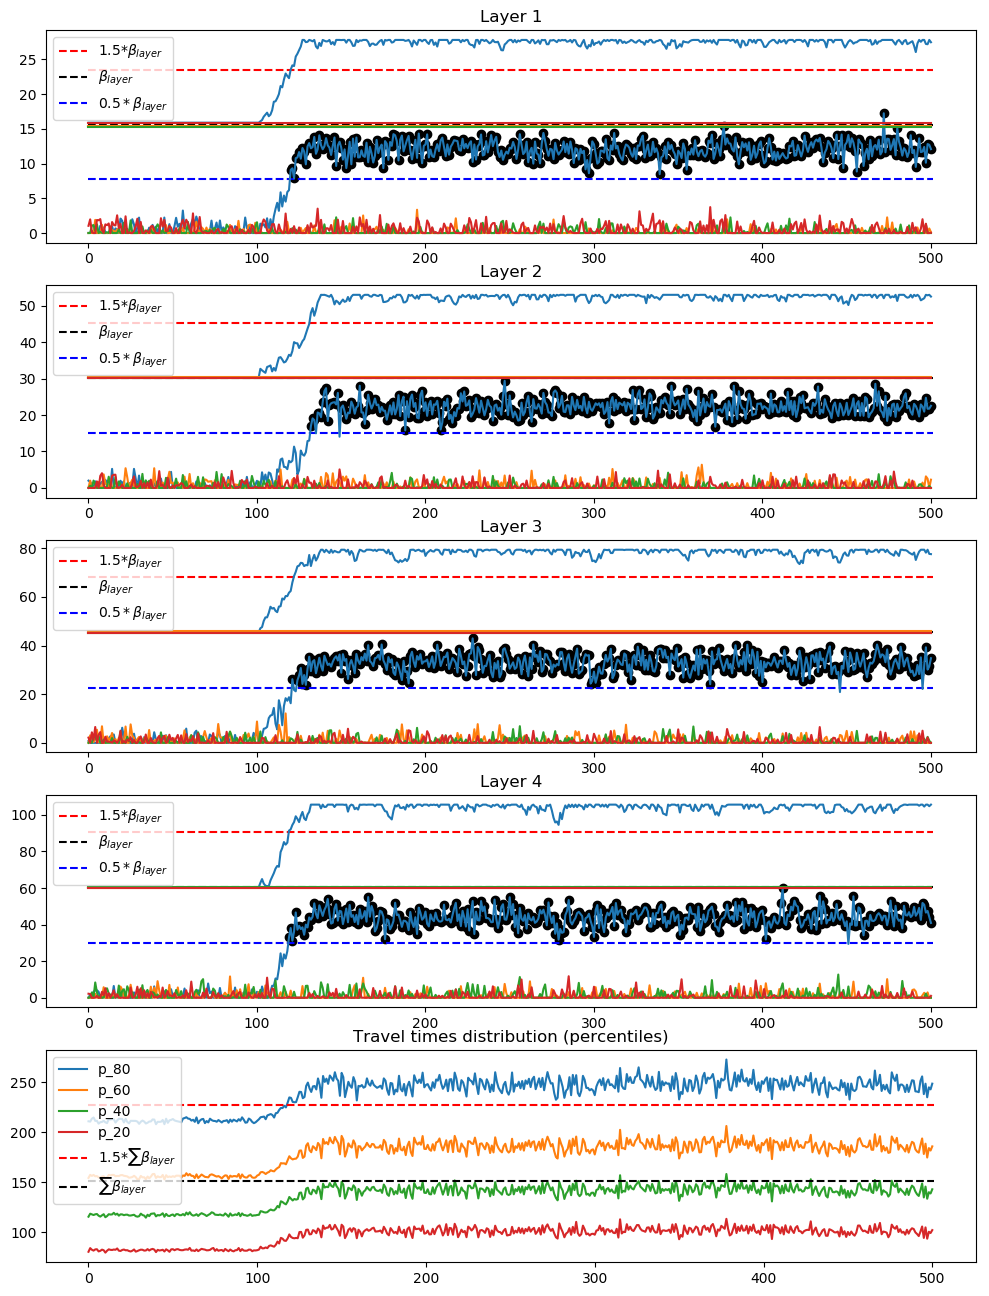

In [153]:
plt.rcParams.update(plt.rcParamsDefault)    
f, ax = plt.subplots(L+1, figsize=(12,16))

colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

for layer in range(L):   
    t = np.mean(orig[layer]) + sla["mu_S"][layer] 
    ax[layer].plot([0, len(diff_mu_approx)], [t, t], "r--", label=r'1.5*$\beta_{layer}$')
    t = np.mean(orig[layer]) 
    ax[layer].plot([0, len(diff_mu_approx)], [t, t], "--", c="black", label=r"$\beta_{layer}$")

    ax[layer].plot([0, len(diff_mu_approx)], [sla["mu_S"][layer], sla["mu_S"][layer]], "b--", label=r"$0.5*\beta_{layer}$")

    ax[layer].scatter([x[0] for x in migrate[layer]], [x[1] for x in migrate[layer]], c="black", marker='o')
    
    for n in range(N):
        ax[layer].plot(diff_mu_approx[:,layer,n], color=colors[n])
        ax[layer].plot(mu[:,layer, n], color=colors[n])
    ax[layer].legend(loc="upper left")
    ax[layer].set_title("Layer " + str(layer+1))


for i in range(4,0,-1):
    label = "p_"+str((i)*20)
    ax[L].plot(percentiles[:,i-1], label=label)
    ax[L].set_title("Travel times distribution (percentiles)")

t = np.mean(orig, axis=1).sum() + np.sum(sla["mu_S"])
ax[L].plot([0, len(diff_mu_approx)], [t, t], "--", c="red", label=r"1.5*$\sum\beta_{layer}$")

t = np.mean(orig, axis=1).sum()
ax[L].plot([0, len(diff_mu_approx)], [t, t], "--", c="black", label=r"$\sum\beta_{layer}$")

ax[L].legend(loc="upper left")
plt.show()

# Experiment 4
- not sure

# Experiment 5
- Traffic load increases. No action.

In [154]:
N = 4
L = 4
distr ={"Q":"exp", "S":"exp"}

graph = init_graph(L, N)
graph["mu_Q"][:] =0

for layer in range(L):
    graph["mu_S"][layer]+=(layer+1)*15
    
graph["var_Q"][:] =0
graph["var_S"][:] =1

sla = {"mu_Q"  : np.zeros(L),
       "var_Q" : np.zeros(L),
       "mu_S"  : np.zeros(L),
       "var_S" : np.zeros(L),
    }

sla_treshold = 0.5 # 50% of layer mean

for l in range(L):
    sla["mu_Q"][l] = np.mean(graph["mu_Q"][l])*sla_treshold
    sla["var_Q"][l] = np.mean(graph["var_Q"][l])*sla_treshold
    sla["mu_S"][l] = np.mean(graph["mu_S"][l])*sla_treshold
    sla["var_S"][l] = np.mean(graph["var_S"][l])*sla_treshold
    
graph["mu_S"], sla

(array([[ 15.64791004,  15.3746057 ,  15.60183545,  15.78398456],
        [ 30.21582494,  30.42460704,  30.23422016,  30.77169022],
        [ 45.54687385,  45.80330236,  45.41357193,  45.23453168],
        [ 60.25434743,  60.00955284,  60.51689381,  60.89973987]]),
 {'mu_Q': array([ 0.,  0.,  0.,  0.]),
  'mu_S': array([  7.80104197,  15.2057928 ,  22.74978498,  30.21006674]),
  'var_Q': array([ 0.,  0.,  0.,  0.]),
  'var_S': array([ 0.5,  0.5,  0.5,  0.5])})

In [155]:
steps = 501
win_size = 1
diff_mu_approx = np.zeros((steps, L, N)) 
mu = np.zeros((steps, L, N))

percentiles = np.zeros((steps, 5))

orig = graph["mu_S"].copy()
orig_q = graph["mu_Q"].copy()

print()

print(orig)
P=500
migrate = defaultdict(list)

for s in range(steps):
    mu[s] = graph["mu_S"] + graph["mu_Q"] 
    travel_times = []
    for layer in range(L):
        diffs, diffs_var, trav_times = approximate_diffs(layer, graph, distr, P)
        travel_times += trav_times        
        
        for node in range(N):
            #compare each node to a random node
            while True:
                rand_node = np.random.choice(N)
                if rand_node != node:
                    diff_mu_approx[s][layer][node] = max(0,diffs[node][rand_node])
                    break
 
            if s > 100 : # regime change --> traffic increases
                graph["mu_Q"][layer][node] += (layer+1)*(np.random.rand()-0.4)
                graph["mu_Q"][layer][node] = np.abs(graph["mu_Q"][layer][node])
                graph["mu_Q"][layer][node] = min(graph["mu_Q"][layer][node], 0.75*orig[layer][node])

            
            len_tt = len(travel_times)          
            
            #    graph["mu_Q"][layer][node] += (layer+1)*(np.random.rand()-0.3)
            #    graph["mu_Q"][layer][node] = max(graph["mu_Q"][layer][node], orig[layer][node])
                
            
    perc_idx = [x for x in range(int(len_tt/5), len_tt+1, int(len_tt/5))]
    perc_idx[-1] = perc_idx[-1]-1
    percentiles[s] = np.array(sorted(travel_times))[perc_idx]
    
graph["mu_S"], graph["mu_Q"]


[[ 15.64791004  15.3746057   15.60183545  15.78398456]
 [ 30.21582494  30.42460704  30.23422016  30.77169022]
 [ 45.54687385  45.80330236  45.41357193  45.23453168]
 [ 60.25434743  60.00955284  60.51689381  60.89973987]]


(array([[ 15.64791004,  15.3746057 ,  15.60183545,  15.78398456],
        [ 30.21582494,  30.42460704,  30.23422016,  30.77169022],
        [ 45.54687385,  45.80330236,  45.41357193,  45.23453168],
        [ 60.25434743,  60.00955284,  60.51689381,  60.89973987]]),
 array([[ 11.67024451,  11.53095427,  11.70137659,  11.58582645],
        [ 22.66186871,  22.81845528,  22.67566512,  23.07876766],
        [ 32.87084754,  34.35247677,  30.13665527,  33.92589876],
        [ 43.83909804,  43.40872673,  45.38767036,  43.35135122]]))

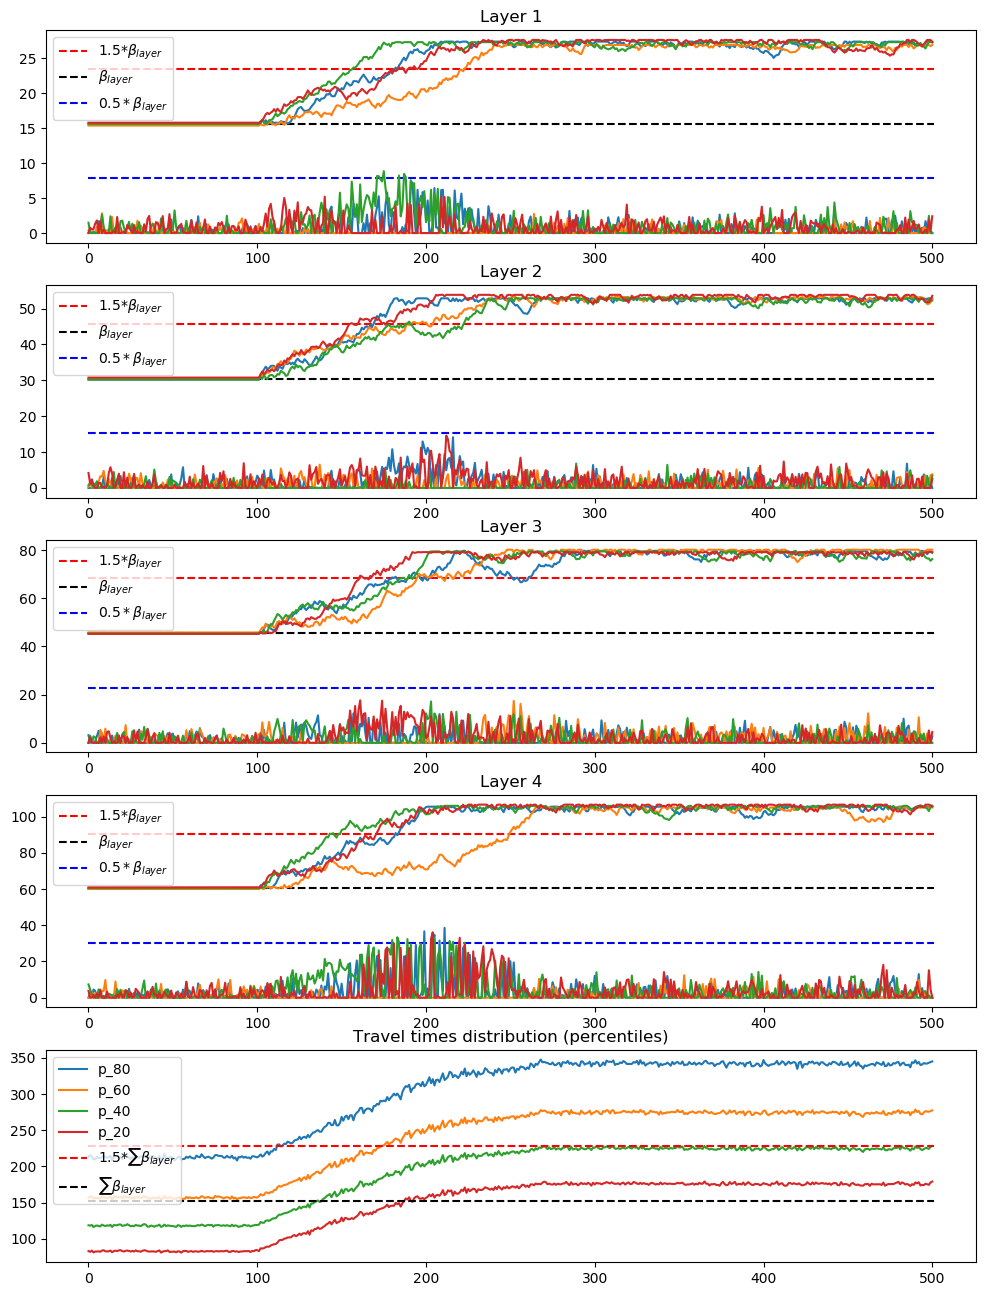

In [156]:
plt.rcParams.update(plt.rcParamsDefault)    
f, ax = plt.subplots(L+1, figsize=(12,16))

colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

for layer in range(L):   
    t = np.mean(orig[layer]) + sla["mu_S"][layer] 
    ax[layer].plot([0, len(diff_mu_approx)], [t, t], "r--", label=r'1.5*$\beta_{layer}$')
    t = np.mean(orig[layer]) 
    ax[layer].plot([0, len(diff_mu_approx)], [t, t], "--", c="black", label=r"$\beta_{layer}$")

    ax[layer].plot([0, len(diff_mu_approx)], [sla["mu_S"][layer], sla["mu_S"][layer]], "b--", label=r"$0.5*\beta_{layer}$")

    ax[layer].scatter([x[0] for x in migrate[layer]], [x[1] for x in migrate[layer]], c="black", marker='o')
    
    for n in range(N):
        ax[layer].plot(diff_mu_approx[:,layer,n], color=colors[n])
        ax[layer].plot(mu[:,layer, n], color=colors[n])
    ax[layer].legend(loc="upper left")
    ax[layer].set_title("Layer " + str(layer+1))


for i in range(4,0,-1):
    label = "p_"+str((i)*20)
    ax[L].plot(percentiles[:,i-1], label=label)
    ax[L].set_title("Travel times distribution (percentiles)")

t = np.mean(orig, axis=1).sum() + np.sum(sla["mu_S"])
ax[L].plot([0, len(diff_mu_approx)], [t, t], "--", c="red", label=r"1.5*$\sum\beta_{layer}$")

t = np.mean(orig, axis=1).sum()
ax[L].plot([0, len(diff_mu_approx)], [t, t], "--", c="black", label=r"$\sum\beta_{layer}$")

ax[L].legend(loc="upper left")
plt.show()

# Experiment 6
- not sure.